In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as it
import functools as ft
from tools import helpers as h
from copy import copy

from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline

### Read in Super/sub cluster 

In [2]:
louv = pd.read_csv('../data/cluster/louvain_clusters.txt', index_col=0, sep='\t')
louv.columns = ['cluster_super']
louv = louv.merge(pd.read_csv('../data/cluster/louvain_small_clusters.txt', index_col=0, sep='\t'), left_index=True, right_index=True)
louv.columns = ['cluster_super', 'cluster_sub']
louv.head()

,cluster_super,cluster_sub
names,,
MST1R,3,11
YES1,3,11
TYRO3,3,11
FGR,3,11
SRC,3,11


In [3]:
hgnc_mapper = h.fetch_hgnc_mapper()

In [4]:
!ls ../data/grmetrics/

broad_hms_lincs.tsv     genentech_cell_line.tsv lincs_mcf10a.tsv
ctrp.tsv                hms_lincs_density.tsv   mep_lincs.tsv


In [5]:
# initial target list -- not for linear programming
klaeger = pd.read_excel('../data/ref/Klaeger_Science_2017 Supplementary Table 6 Selectivities.xlsx', sheet_name='CATDS target')

# a number of drugs have very similar targets listed in the same row
# we parse to separate these out 
double_drug_targets = klaeger[klaeger['Target'].apply(lambda x: ';' in x)]

# get the first and second gene
first_genes = double_drug_targets['Target'].apply(lambda x: x.split(';')[0])
second_genes = double_drug_targets['Target'].apply(lambda x: x.split(';')[1])

# fix the double targets
repaired_double_targets = double_drug_targets.drop('Target', axis=1).assign(**{'Target':first_genes})
repaired_double_targets = repaired_double_targets.append(double_drug_targets.drop('Target', axis=1).assign(**{'Target':second_genes})) 
klaeger = klaeger.drop(double_drug_targets.index).append(repaired_double_targets, sort=False)

# filter to only hgnc keys
klaeger = klaeger[klaeger.Target.isin(hgnc_mapper.keys())]

# convert to hgnc
klaeger.Target = klaeger.Target.apply(lambda x: hgnc_mapper[x])

# filter to our kinases
klaeger = klaeger[klaeger.Target.isin(set(louv.index))]

# save total drug list information
drug_list = list(sorted(set(klaeger.Drug)))
print(len(drug_list), ' drugs present for our analysis')

# sort columns
klaeger = klaeger[['Target', 'Drug', 'At', 'CATDS']]

klaeger['Drug'] = [x.lower().replace('-', '') for x in klaeger.Drug]
klaeger.head()

217  drugs present for our analysis


,Target,Drug,At,CATDS
0,AURKA,mk5108,0.120921,0.657165
1,CHEK1,pf477736,0.243725,0.733257
2,FLT3,dovitinib,0.265240,0.860803
4,MET,capmatinib,0.337514,1.000000
5,MAPKAPK2,vx702,0.342705,0.743594


In [6]:
klaeger_drugs = set(klaeger.Drug)
print(len(klaeger_drugs), 'drugs in the Klaeger 2017 Science Paper with known targets')

217 drugs in the Klaeger 2017 Science Paper with known targets


In [7]:
datasets = ['broad_hms_lincs.tsv', 'genentech_cell_line.tsv', 
            'lincs_mcf10a.tsv', 'ctrp.tsv',
            'hms_lincs_density.tsv', 'mep_lincs.tsv']

abbrevs = ['broad_hms', 'genentech', 'lincs_mcf', 'ctrp', 'hms_density', 'mep']

datadict = {a:pd.read_csv('../data/grmetrics/'+d, sep='\t') for a,d in list(zip(abbrevs, datasets))}

for name,data in datadict.items():
    print(name,':\tsize',data.shape)
    display(data.head())

broad_hms :	size (642, 12)


,Cell_HMSLID,Cell_Line,Small_Mol_HMSLID,Small_Molecule,GR50,GEC50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_r2,pval
0,50105-3,BT-20,10001-101-1,Seliciclib,5.677700,14.42560,0.194160,-1.00000,1.17820,0.17548,9.722700e-01,7.689100e-04
1,50105-3,BT-20,10045-101-1,A443654,0.053033,0.23019,-0.492210,-0.63357,0.55758,1.00120,9.874300e-01,1.579200e-04
2,50105-3,BT-20,10133-101-1,Afatinib,inf,0.00000,0.054486,0.68319,0.01000,0.25541,-1.060000e-12,1.290800e-01
3,50105-3,BT-20,10004-101-1,AT-7519,0.204440,0.32038,-0.401780,-0.40563,1.32240,0.86351,9.993600e-01,4.140000e-07
4,50105-3,BT-20,10158-101-1,AZD 5438,0.245910,0.55040,-0.354640,-0.44610,0.79155,0.74810,9.909100e-01,8.250000e-05


genentech :	size (6167, 18)


,Cell_Line,DoublingTime,Tissue,Perturbagen,GR50,GEC50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_r2,IC50,Emax,AUC,IC_r2,CDC73_del,BCL2_del,PTEN_mut
0,1321N1,23,Brain,bid1870,31.000000,1000.000000,0.81607,0.388820,0.24661,0.066971,0.68658,31.000000,0.739340,0.90021,0.68569,NaN,NaN,NaN
1,1321N1,23,Brain,bortezomib,0.045432,0.063644,-0.63780,-0.640180,2.44540,0.509780,0.99919,0.039072,0.004753,0.63654,0.99806,NaN,NaN,NaN
2,1321N1,23,Brain,crizotinib,1.344200,2.197400,0.70570,-0.999270,2.23430,0.056496,0.67633,1.194200,0.607570,0.91825,0.60390,NaN,NaN,NaN
3,1321N1,23,Brain,docetaxel,0.004362,0.004333,0.00624,0.004647,1.39340,0.482830,0.99431,0.003182,0.116440,0.52438,0.99766,NaN,NaN,NaN
4,1321N1,23,Brain,doxorubicin,0.128300,0.203860,-0.56468,-0.537030,1.57540,0.799740,0.99292,0.098516,0.008452,0.40325,0.99912,NaN,NaN,NaN


lincs_mcf :	size (152, 10)


,Cell_Line,Small_Molecule,GR50,GEC50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_r2,Replicate
0,Isolate 1 - HMS,Alpelisib,14.6463,76.5784,0.57934,-1.00000,0.66416,0.085282,0.99239,HMS R1
1,Isolate 1 - HMS,Alpelisib,4.9885,28.7866,0.31350,-1.00000,0.62678,0.166000,0.99188,HMS R2
2,Isolate 1 - HMS,Alpelisib,9.4622,49.3942,0.46986,-0.99998,0.66480,0.106260,0.99083,HMS R3
3,Isolate 2 - HMS,Alpelisib,19.9827,54.4563,0.72384,-0.97835,1.08130,0.033366,0.98580,HMS R1
4,Isolate 2 - HMS,Alpelisib,61.2517,17.9647,0.78534,0.37406,1.12410,0.028478,0.97344,HMS R2


ctrp :	size (65945, 9)


,Cell_Line,Perturbagen,GR50,GEC50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_r2
0,786O,16-beta-bromoandrosterone,inf,inf,0.93115,0.93115,0.00000,0.020524,0.18804
1,786O,"1S,3R-RSL-3",0.038678,0.047649,-0.89921,-0.91886,5.00000,1.181700,0.99115
2,786O,3-Cl-AHPC,0.952640,1.225600,-0.35674,-0.33655,2.04240,0.515340,0.99784
3,786O,A-804598,inf,1000.000000,0.76195,0.31483,0.39217,0.063627,0.43201
4,786O,AA-COCF3,inf,inf,0.95043,0.95043,0.00000,0.002046,0.24800


hms_density :	size (1008, 22)


,Cell_HMSLID,Cell_Line,Small_Mol_HMSLID,Small_Molecule,Replicate,Density,IC50,EC50,Emax,Einf,...,IC_Curve_Fit,IC_r2,GR50,GEC50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_Curve_Fit,GR_r2
0,50029-3,MCF7,10024-101-1,NVP-TAE684,1,156.25,0.1519,0.0644,0.3193,0.3262,...,sigmoidal fit: x = Einf + (1-Einf)/(1+ (x/EC50...,0.6193,0.0650,0.0749,-0.1298,-0.1020,1.3170,0.6318,sigmoidal fit: x = Einf + (1-Einf)/(1+ (x/EC50...,0.6437
1,50029-3,MCF7,10024-101-1,NVP-TAE684,1,312.50,0.4509,0.2457,0.2754,0.2733,...,sigmoidal fit: x = Einf + (1-Einf)/(1+ (x/EC50...,0.9794,0.2018,0.2687,-0.2296,-0.2307,1.3254,0.5092,sigmoidal fit: x = Einf + (1-Einf)/(1+ (x/EC50...,0.9843
2,50029-3,MCF7,10024-101-1,NVP-TAE684,1,625.00,0.2192,0.0990,0.2678,0.2470,...,sigmoidal fit: x = Einf + (1-Einf)/(1+ (x/EC50...,0.9380,0.0695,0.1098,-0.2274,-0.2493,0.8837,0.6602,sigmoidal fit: x = Einf + (1-Einf)/(1+ (x/EC50...,0.9391
3,50029-3,MCF7,10024-101-1,NVP-TAE684,1,1250.00,0.1798,0.1022,0.2463,0.2465,...,sigmoidal fit: x = Einf + (1-Einf)/(1+ (x/EC50...,0.9930,0.0842,0.1223,-0.2788,-0.2814,1.1945,0.6383,sigmoidal fit: x = Einf + (1-Einf)/(1+ (x/EC50...,0.9948
4,50029-3,MCF7,10024-101-1,NVP-TAE684,1,2500.00,0.1816,0.1092,0.2284,0.2285,...,sigmoidal fit: x = Einf + (1-Einf)/(1+ (x/EC50...,0.9869,0.0998,0.1392,-0.2196,-0.2296,1.1347,0.5990,sigmoidal fit: x = Einf + (1-Einf)/(1+ (x/EC50...,0.9911


mep :	size (9248, 18)


,Cell_HMSLID,Cell_Line,Clinical_Subtype,Transcriptional_Subtype,Perturbagen_HMSLID,Perturbagen,Perturbagen_Target,Perturbagen_Class,Replicate_ID,Conc_Unit,GR50,GEC50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_r2,Nominal_Div_Rate
0,51088-1,184A1,NM,Basal,10275-101-1,(Z)-4-Hydroxytamoxifen,ESR1,NaN,9047.132,uM,inf,inf,0.4055,0.4055,0.0000,0.2074,0.3073,0.6985
1,51088-1,184A1,NM,Basal,10236-101-1,17-AAG,HSP90,HSP90,9047.037,uM,0.00930,0.01282,-0.9826,-0.6989,2.7212,1.1760,0.9539,0.5262
2,51088-1,184A1,NM,Basal,10237-101-1,5-DFUR,TYMS,TYMS,12509.143,uM,228.63720,1000.00000,-0.2404,-0.6424,0.5600,0.2642,0.9697,1.3392
3,51088-1,184A1,NM,Basal,10238-101-1,5-FU,TYMS,TYMS,9047.017,uM,48.19500,95.97100,-0.8459,-0.8556,1.4480,0.8094,0.9747,0.8440
4,51088-1,184A1,NM,Basal,10133-101-2,Afatinib,EGFR/HER2,ErbB,12509.165,uM,0.02251,0.33740,-0.9088,-1.0000,0.4058,0.8284,0.9307,1.5022


In [8]:
klaeger_drugs = set([x.lower().replace('-', '') for x in klaeger_drugs])

for name,data in datadict.items():
    try:
        local_drug_set = set(data.Perturbagen)
    except:
        local_drug_set = set(data.Small_Molecule)
        
    local_drug_set = set([x.lower().replace('-','').replace(' ', '') for x in local_drug_set])
    
    print(len(local_drug_set), 'total drugs in', name)
    print(np.round(len(local_drug_set & klaeger_drugs)*100.0/len(klaeger_drugs),3), '% of Klaeger present\n')

107 total drugs in broad_hms
21.659 % of Klaeger present

16 total drugs in genentech
1.382 % of Klaeger present

8 total drugs in lincs_mcf
1.843 % of Klaeger present

545 total drugs in ctrp
29.032 % of Klaeger present

12 total drugs in hms_density
2.765 % of Klaeger present

107 total drugs in mep
7.373 % of Klaeger present



In [10]:
for name, data in datadict.items():
    # splice molecule into a different field
    # remove '-' and ' ' from molecule names
    try:
        data['molecule'] = copy(data.Perturbagen.apply(lambda x: x.lower().replace('-', '').replace(' ', '')))
    except:
        data['molecule'] = copy(data.Small_Molecule.apply(lambda x: x.lower().replace('-', '').replace(' ', '')))
        
    data = data[['molecule', 'GR50', 'GRmax', 'GRinf', 'GR_Hill_Coeff', 'GR_AOC', 'GR_r2']]
        
    datadict[name] = data

In [87]:
agg = pd.concat([data for data in datadict.values()], ignore_index=True)
display(agg.shape)
display(agg.head(10))
display(agg.describe())

(83162, 7)

,molecule,GR50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_r2
0,seliciclib,5.677700,0.194160,-1.000000,1.17820,0.17548,9.722700e-01
1,a443654,0.053033,-0.492210,-0.633570,0.55758,1.00120,9.874300e-01
2,afatinib,inf,0.054486,0.683190,0.01000,0.25541,-1.060000e-12
3,at7519,0.204440,-0.401780,-0.405630,1.32240,0.86351,9.993600e-01
4,azd5438,0.245910,-0.354640,-0.446100,0.79155,0.74810,9.909100e-01
5,azd6482,1.286700,-0.081485,-0.548250,0.76277,0.42682,9.988100e-01
6,azd7762,0.653730,-0.407380,-0.569420,1.00760,0.58180,9.895100e-01
7,azd8055,-inf,-0.223940,-1.000000,0.16953,0.92212,9.223300e-01
8,azd8330,inf,0.784780,0.748880,0.01000,0.24961,0.000000e+00
9,barasertib,0.246680,-0.013290,-0.066258,0.71297,0.64146,9.919900e-01


,GR50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_r2
count,8.316200e+04,83162.000000,83162.000000,83162.000000,83162.000000,83162.00000
mean,NaN,0.001954,-0.169606,1.986911,0.301824,-inf
std,NaN,0.697329,0.755661,1.851131,0.317119,NaN
min,-inf,-1.000000,-1.000000,0.000000,-0.112400,-inf
25%,1.336025e+00,-0.666708,-0.980508,0.417700,0.058600,0.53752
50%,1.549750e+01,-0.042000,-0.324870,1.335800,0.209990,0.90822
75%,inf,0.689810,0.583223,3.605475,0.452308,0.97353
max,inf,1.143600,1.050000,5.000000,1.998600,1.00000


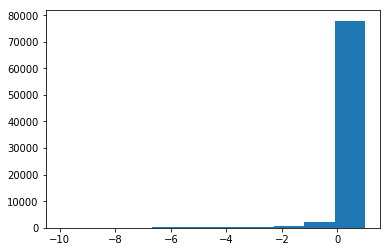

In [88]:
plt.hist(agg[np.abs(agg.GR_r2) < 10].GR_r2)
plt.show()

In [89]:
agg[agg.GR_r2 == agg.GR_r2.min()]

,molecule,GR50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_r2
5471,docetaxel,31.0,1.05,1.05,0.0,-0.05,-inf
6723,ms275,31.0,1.05,1.05,0.0,-0.05,-inf
20519,bms536924,inf,1.05,1.05,0.0,-0.05,-inf
20712,pik93,inf,1.05,1.05,0.0,-0.05,-inf
20753,tw37,inf,1.05,1.05,0.0,-0.05,-inf
20777,betulinicacid,inf,1.05,1.05,0.0,-0.05,-inf
20923,sitagliptin,inf,1.05,1.05,0.0,-0.05,-inf
23301,agk2,inf,1.05,1.05,0.0,-0.05,-inf
23318,bms536924,inf,1.05,1.05,0.0,-0.05,-inf
23472,ml029,inf,1.05,1.05,0.0,-0.05,-inf


In [90]:
agg['inf_50'] = 1.0*(agg.GR50==agg.GR50.max())
agg['missing_50'] = 1.0*(agg.GR50==agg.GR50.min())
agg['normal_50'] = 1.0-agg.inf_50.values-agg.missing_50.values

# replace inf values in GR50
agg['GR50'] = copy(agg.GR50.replace(agg.GR50.min(), -2).replace(agg.GR50.max(), -1))

# shifted log transform of GR50
agg['GR50'] = copy(agg.GR50).apply(lambda x: np.log(x+1) if x > -1 else x)

# drop the -inf r2 values
agg.drop(agg[agg.GR_r2 == agg.GR_r2.min()].index, axis=0, inplace = True)

# drop weird r2 values -- may want to add np.isclose for precision issues
agg = agg[agg.GR_r2 >= -1.0]

# drop weird GRinf values -- ditto np.close
agg = agg[agg.GRinf <= 1.0]

# drop weird GRmax values -- ditto
agg = agg[agg.GRmax <= 1.0]

In [91]:
agg.describe()

,GR50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_r2,inf_50,missing_50,normal_50
count,76241.000000,76241.000000,76241.000000,76241.000000,76241.000000,76241.000000,76241.000000,76241.000000,76241.000000
mean,1.275822,-0.091718,-0.275250,2.139678,0.328650,0.771073,0.210884,0.003738,0.785378
std,1.845113,0.651858,0.697033,1.826794,0.315856,0.317369,0.407939,0.061026,0.410563
min,-2.000000,-1.000000,-1.000000,0.000000,-0.112400,-0.996840,0.000000,0.000000,0.000000
25%,0.008541,-0.709990,-0.999700,0.640290,0.085580,0.694810,0.000000,0.000000,1.000000
50%,0.975012,-0.154890,-0.452930,1.495100,0.241400,0.925100,0.000000,0.000000,1.000000
75%,2.766445,0.513490,0.345640,3.976000,0.479500,0.976470,0.000000,0.000000,1.000000
max,9.597628,1.000000,1.000000,5.000000,1.998600,1.000000,1.000000,1.000000,1.000000


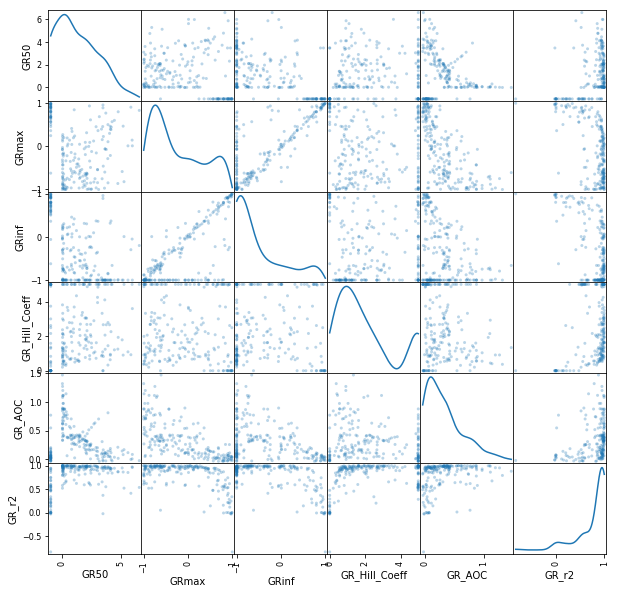

In [95]:
pd.plotting.scatter_matrix(agg[agg.columns[:7]].sample(200),diagonal='kde', alpha=.3, figsize=(10,10))
plt.show()

In [96]:
agg.to_csv('../data/modelInputs/input_grMetrics.tsv', sep='\t', index=False, header=True)